# PyTorch and WaveNet


In this course, we are inspired by the architecture of the [WaveNet](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/) model proposed by Google DeepMind for audio processing. Our goal is to use a larger number of characters for the context of our next-word predictor.


## Architecture


The architecture of a WaveNet is a hierarchical architecture that gives more weight to the closest context elements.


Here is what the architecture looks like:

![WaveNet](./images/wavenet.png)

Figure extracted from the original article.


## Implementing the Fully Connected Model with PyTorch


The course begins with an adaptation of the concepts from the previous lesson using PyTorch functions.


### Dataset


In [38]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import TensorDataset, DataLoader, random_split

%matplotlib inline

In [39]:
# Lecture du dataset
words = open('prenoms.txt', 'r').read().splitlines()
print(words[:8])

['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ', 'JEANNE', 'PHILIPPE', 'LOUIS']


In [40]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

For a change, let's increase the context from 3 to 8. This will give us a performance indicator as we will also use 8 for our WaveNet.


In [41]:
block_size = 8 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] 
X = torch.tensor(X)
Y = torch.tensor(Y)

In [42]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Model Creation and Training


To start, we will reimplement the model from the previous notebook, but with PyTorch.


In [43]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class fcn(nn.Module):
  def __init__(self,embed_dim=10,context_len=8,hidden_dim=300, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.embed_dim=embed_dim
    self.context_len=context_len
    
    #La fonction nn.Embedding de pytorch est l'équivalent de la matrice C 
    self.embedding=nn.Embedding(46,embed_dim)
    self.layer1=nn.Linear(embed_dim*context_len,hidden_dim)
    self.layer2=nn.Linear(hidden_dim,46)

  def forward(self,x):       
    embed=self.embedding(x) # Remplace la matrice C
    embed=embed.view(-1,self.embed_dim*self.context_len)
    hidden=F.tanh(self.layer1(embed))
    logits=self.layer2(hidden)
    return logits


In [45]:
model=fcn(context_len=8)
epochs=50
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

**Notes**: To exactly reproduce the code from the previous notebook, you will need to reduce the learning rate by a factor of 10 at the halfway point of training. In PyTorch, this can be done using a [*scheduler*](https://pytorch.org/docs/stable/optim.html). There are several types of schedulers: *LambdaLR* (to change the learning rate based on a function), *StepLR* (to decrease the learning rate every *n* epochs), *LinearLR* (to decrease the learning rate linearly), *ReduceLROnPlateau* (to decrease the learning rate as soon as the loss stops changing), *OneCycleLR* (to start with a low learning rate, then increase and decrease it), and many others.

To speed up model convergence, I would recommend using *OneCycleLR* (for more information, see this [blogpost](https://www.datacamp.com/tutorial/cyclical-learning-neural-nets)). To obtain a very performant model, I would rather recommend *ReduceLROnPlateau*. In any case, it is interesting to experiment with the different schedulers yourself.


In [46]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    # Mise à jour des poids du modèle
    optimizer.step()
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 2.487, Validation loss: 2.427
Epoch 10 - Training loss: 2.056, Validation loss: 2.151
Epoch 20 - Training loss: 1.952, Validation loss: 2.114
Epoch 30 - Training loss: 1.896, Validation loss: 2.146
Epoch 40 - Training loss: 1.864, Validation loss: 2.092


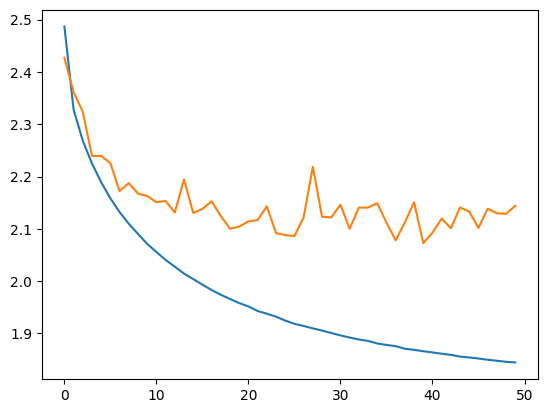

In [47]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

The difference between the training and validation curves indicates that the model is slightly overfitting.


In [48]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
model.eval()
loss_test=0
for x,y in test_loader:
    
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.1220, grad_fn=<DivBackward0>)


The test loss is slightly higher than the training loss, so the model is slightly overfitting, but it remains minor, and we still have room to increase the network's capacity. We can now check the quality of the name generation.


In [49]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

LOUIS-ANDRÉ.
YOHES.
BRES.
TERIGAND.
CONKHE.


The generated names are correct but can be improved. Let's see if we can achieve a better loss on the test data with the WaveNet approach.


## Implementing WaveNet with PyTorch


The dataset is the same as for the previous part, no need to change anything.


### How to Handle the Hierarchical Architecture


What we want in our model is to process groups of *embeddings* in parallel by grouping consecutive characters. In PyTorch, if we pass a tensor of size $B \times L \times C$ through a linear layer of size $C \times H$, we get a tensor of size $B \times L \times H$, which is exactly what we need to implement the WaveNet network.


Now, we need to find how to modify the tensor size to perform the WaveNet operations. Our 8 *embeddings* are grouped in pairs and then processed in parallel. In the next layer, they are grouped in pairs again. Therefore, at each step, we double the size $H$ (or $C$) and halve $L$.


In [50]:
dummy=torch.randn([256,8,10])
# On divise par deux L et on double H/C
dummy=dummy.view(-1,dummy.shape[1]//2,dummy.shape[2]*2)
print(dummy.shape)

torch.Size([256, 4, 20])


To be clearer, at the first step, we have a tensor of size $B \times 8 \times 10$ that we want to transform into a tensor of size $B \times 4 \times 20$. We can implement this with PyTorch's [*view()*](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html).


In [51]:
class FlattenConsecutive(nn.Module):
  # n est le facteur de regroupement (toujours 2 pour nous)
  def __init__(self, n):
    super(FlattenConsecutive, self).__init__()
    self.n = n   
  def __call__(self, x):
    # On récupère les dimensions de l'entrée
    B, T, C = x.shape 
    # On fait la transformation x2 et /2
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: 
      x = x.squeeze(1) # Si le tensor a une dimension qui vaut 1, on la supprime
    self.out = x
    return self.out

Let's try to formalize this with a layer that we can use in our network:


### Model Creation


In [52]:
class wavenet(nn.Module):
  def __init__(self,embed_dim=10,hidden_dim=128, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    
    self.net=nn.Sequential(nn.Embedding(46,embed_dim),
      # B*8*10
      FlattenConsecutive(2), nn.Linear(embed_dim*2,hidden_dim),nn.Tanh(),
      # B*4*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*2*hidden_dim
      FlattenConsecutive(2), nn.Linear(hidden_dim*2,hidden_dim),nn.Tanh(),
      # B*hidden_dim
      nn.Linear(hidden_dim,46)
    )   
        
  def forward(self,x):
    logits=self.net(x)
    return logits


We initialize our model and the hyperparameters.


In [53]:
model=wavenet()
epochs=40
lr=0.2
optimizer=torch.optim.SGD(model.parameters(),lr=lr)
for p in model.parameters():
  p.requires_grad = True

And we start the training.


In [54]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    # retropropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Mise à jour des poids du modèle
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    logits=model(x)
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")
  

Epoch 0 - Training loss: 2.541, Validation loss: 2.459
Epoch 10 - Training loss: 2.013, Validation loss: 2.094
Epoch 20 - Training loss: 1.898, Validation loss: 2.096
Epoch 30 - Training loss: 1.834, Validation loss: 2.060


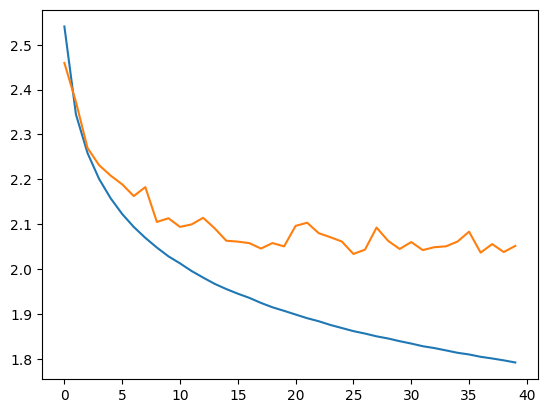

In [55]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

In [56]:
model.eval()
loss_test=0
for x,y in test_loader:
      
  # forward pass
  logits=model(x)
  loss = F.cross_entropy(logits, y)
      
  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.0132, grad_fn=<DivBackward0>)


We obtain a very good loss, lower than that of the Fully Connected model with a context of 8.

**Notes**: By looking at the validation curve compared to the training curve, we realize there might be a problem (and the same with the Fully Connected model with a context of 8). It's up to you to see if you can correct this problem with what you have learned in the previous courses (see [course on fully connected networks](../02_RéseauFullyConnected/README.md)).


In [68]:
for _ in range(5):
  out = []
  context = [0] * block_size 
  while True:
    logits=model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

MARICE.
JEXE.
RAYEDE.
CHAHI.
RISHAE.


Name generation is getting better and better!


**Exercise**: To practice, try modifying the training parameters, network architecture, and other aspects to achieve a loss of less than 2.0 on the test data. Bonus points if you reduce the number of model parameters.
